In [30]:
import websocket
import requests
import json
import pandas as pd
#! conda install -c conda-forge ta --yes
import ta
import matplotlib.pyplot as plt
import math
import pytz

In [31]:
timezone = pytz.timezone("Asia/Taipei")
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
rate = 30
interval = '15m'
limit = rate*3

In [32]:
data = json.dumps({'method':'SUBSCRIBE','params':[symbol + '@kline_' + interval],'id':1})
df = pd.DataFrame()

In [33]:
def get_historical(symbol, interval, limit):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol_C,
              "interval": interval,
              "limit": limit}
    response = requests.get(url, params=params).json()
    df = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                           "Volume", "Close time", "Quote asset volume",
                                           "Number of trades", "Taker buy base asset volume",
                                           "Taker buy quote asset volume", "Ignore"])
    df = df[['Close time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    df = df.astype(convert_dict)
    return df

In [34]:
if df.shape[0] < rate:
    df = get_historical(symbol, interval, limit)
    df.index = df['Close time']
    df.drop(['Close time'], axis =1, inplace=True)
    df['Closed'] = True
    # sma = get_sma(df['Close'], rate)
    # bband_up, bband_down = get_bollinger_bands(df['Close'], sma, rate)
    # df['Sma'] = sma
    # df['Bb_U'] = bband_up
    # df['Bb_D'] = bband_down
    # df.dropna(inplace=True)
    print(df)

                  Open    Close     High      Low     Volume  Closed
Close time                                                          
1675951199999  1637.61  1640.15  1640.84  1636.50  2332.8964    True
1675952099999  1640.16  1639.69  1642.61  1639.68  5420.0842    True
1675952999999  1639.69  1642.80  1644.78  1639.06  3410.9020    True
1675953899999  1642.81  1636.53  1649.24  1635.97  8722.1726    True
1675954799999  1636.53  1637.59  1645.00  1635.67  5349.5778    True
...                ...      ...      ...      ...        ...     ...
1676027699999  1546.15  1544.26  1546.15  1538.75  3962.3168    True
1676028599999  1544.26  1539.51  1544.79  1537.54  4139.6152    True
1676029499999  1539.51  1537.95  1540.62  1536.49  5265.8331    True
1676030399999  1537.96  1537.03  1539.53  1534.04  6713.0007    True
1676031299999  1537.04  1536.12  1539.44  1535.19  2138.3386    True

[90 rows x 6 columns]


In [16]:
def on_open(ws):
    ws.send(data)

def on_message(ws, message):
    global df, rate, limit
    out = json.loads(message)    
    out = pd.DataFrame({'Open':float(out['k']['o']),
                        'Close':float(out['k']['c']),
                        'High':float(out['k']['h']),
                        'Low':float(out['k']['l']),
                        'Volume':float(out['k']['v']),
                        'Closed':bool(out['k']['x']),
                        },
                        index=[out['E']])


    # out['Sma'] = sma.tail(1)[0]
    # out['Bb_U'] = bband_up.tail(1)[0]
    # out['Bb_D'] = bband_down.tail(1)[0]
    df = pd.concat([df,out], axis = 0)


    
    print(df)
    # df = df.tail(5)
    # df.drop(df[df['closed'] == False].index, axis=0, inplace=True)



In [12]:
ws = websocket.WebSocketApp(endpoint, on_message = on_message, on_open = on_open)
ws.run_forever()

                  Open    Close     High      Low     Volume  Closed
1675950299999  1634.74  1637.60  1642.36  1634.73  4039.9161    True
1675951199999  1637.61  1640.15  1640.84  1636.50  2332.8964    True
1675952099999  1640.16  1639.69  1642.61  1639.68  5420.0842    True
1675952999999  1639.69  1642.80  1644.78  1639.06  3410.9020    True
1675953899999  1642.81  1636.53  1649.24  1635.97  8722.1726    True
...                ...      ...      ...      ...        ...     ...
1676029702753  1537.96  1536.41  1539.53  1535.92  2031.4330   False
1676029704879  1537.96  1536.45  1539.53  1535.92  2032.5326   False
1676029708221  1537.96  1536.58  1539.53  1535.92  2054.6577   False
1676029710483  1537.96  1536.57  1539.53  1535.92  2054.9995   False
1676029730134  1537.96  1537.14  1539.53  1535.92  2183.0107   False

[96 rows x 6 columns]
                  Open    Close     High      Low     Volume  Closed
1675950299999  1634.74  1637.60  1642.36  1634.73  4039.9161    True
16759511999

                  Open    Close     High      Low     Volume  Closed
1675950299999  1634.74  1637.60  1642.36  1634.73  4039.9161    True
1675951199999  1637.61  1640.15  1640.84  1636.50  2332.8964    True
1675952099999  1640.16  1639.69  1642.61  1639.68  5420.0842    True
1675952999999  1639.69  1642.80  1644.78  1639.06  3410.9020    True
1675953899999  1642.81  1636.53  1649.24  1635.97  8722.1726    True
...                ...      ...      ...      ...        ...     ...
1676029744016  1537.96  1536.45  1539.53  1535.92  2243.9082   False
1676029746224  1537.96  1536.43  1539.53  1535.92  2244.8347   False
1676029748358  1537.96  1536.46  1539.53  1535.92  2289.1311   False
1676029750372  1537.96  1536.45  1539.53  1535.92  2306.3010   False
1676029752868  1537.96  1536.35  1539.53  1535.92  2310.4122   False

[106 rows x 6 columns]
                  Open    Close     High      Low     Volume  Closed
1675950299999  1634.74  1637.60  1642.36  1634.73  4039.9161    True
1675951199

                  Open    Close     High      Low     Volume  Closed
1675950299999  1634.74  1637.60  1642.36  1634.73  4039.9161    True
1675951199999  1637.61  1640.15  1640.84  1636.50  2332.8964    True
1675952099999  1640.16  1639.69  1642.61  1639.68  5420.0842    True
1675952999999  1639.69  1642.80  1644.78  1639.06  3410.9020    True
1675953899999  1642.81  1636.53  1649.24  1635.97  8722.1726    True
...                ...      ...      ...      ...        ...     ...
1676029767125  1537.96  1536.06  1539.53  1535.92  2359.5079   False
1676029769226  1537.96  1536.07  1539.53  1535.92  2360.7005   False
1676029771775  1537.96  1536.07  1539.53  1535.92  2365.4626   False
1676029774226  1537.96  1536.17  1539.53  1535.92  2366.5837   False
1676029776308  1537.96  1536.52  1539.53  1535.92  2414.8780   False

[116 rows x 6 columns]
                  Open    Close     High      Low     Volume  Closed
1675950299999  1634.74  1637.60  1642.36  1634.73  4039.9161    True
1675951199

                  Open    Close     High      Low     Volume  Closed
1675950299999  1634.74  1637.60  1642.36  1634.73  4039.9161    True
1675951199999  1637.61  1640.15  1640.84  1636.50  2332.8964    True
1675952099999  1640.16  1639.69  1642.61  1639.68  5420.0842    True
1675952999999  1639.69  1642.80  1644.78  1639.06  3410.9020    True
1675953899999  1642.81  1636.53  1649.24  1635.97  8722.1726    True
...                ...      ...      ...      ...        ...     ...
1676029789045  1537.96  1535.36  1539.53  1535.00  3209.4805   False
1676029791102  1537.96  1535.36  1539.53  1535.00  3220.0660   False
1676029793227  1537.96  1535.36  1539.53  1535.00  3220.6382   False
1676029795264  1537.96  1535.11  1539.53  1535.00  3239.2500   False
1676029797311  1537.96  1535.00  1539.53  1535.00  3308.4512   False

[126 rows x 6 columns]


False

In [21]:
def indicators(df):
    df['SMA_' + str(rate)] = ta.trend.sma_indicator(df.Close, window=rate)
    df.dropna(inplace=True)
        
    sma = get_sma(df['Close'], rate)
    bband_up, bband_down = get_bollinger_bands(df['Close'], sma, rate)
    return df

In [22]:
indicators(df)

,Open,Close,High,Low,Volume,Closed,SMA_30
1675976399999,1579.99,1577.10,1582.45,1576.04,6751.0868,True,1617.383333
1675977299999,1577.10,1571.02,1578.07,1568.41,7019.7317,True,1615.164000
1675978199999,1571.02,1560.80,1574.21,1560.80,9062.5749,True,1612.519000
1675979099999,1560.81,1544.51,1561.71,1526.02,42780.3438,True,1609.346333
1675979999999,1544.52,1540.55,1546.06,1524.40,19846.1478,True,1605.938000
...,...,...,...,...,...,...,...
1676029789045,1537.96,1535.36,1539.53,1535.00,3209.4805,False,1536.167000
1676029791102,1537.96,1535.36,1539.53,1535.00,3220.0660,False,1536.130667
1676029793227,1537.96,1535.36,1539.53,1535.00,3220.6382,False,1536.090000
1676029795264,1537.96,1535.11,1539.53,1535.00,3239.2500,False,1536.041333


In [35]:
def get_sma(close_p, rate = 30):
    return close_p.rolling(rate).mean()

sma = get_sma(df['Close'], rate)

def get_bollinger_bands(close_p, sma, rate = 30):
    std = close_p.rolling(rate).std()
    bband_up = sma + 2 * std
    bband_down = sma - 2 * std
    return bband_up, bband_down

bband_up, bband_down = get_bollinger_bands(df['Close'], rate)


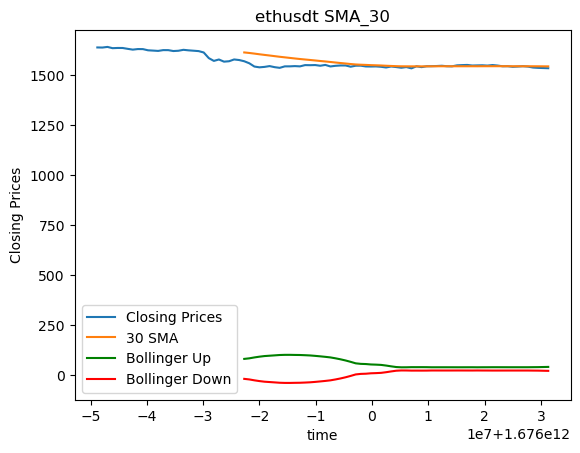

In [36]:
plt.title(symbol + ' SMA_' + str(rate))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(sma, label= str(rate) + ' SMA')
plt.plot(bband_up, label='Bollinger Up', c='g')
plt.plot(bband_down, label='Bollinger Down', c='r')
plt.legend()
plt.show()